# Molecular Dynamics Data Processing

Lei Lei, University of Nottingham

## Trajectory file reading and calibration

### Calibration of trajectory by centre of mass.

#### Method 1. Use `ase`. This method is very slow when the trajectory file is large because ase creates the Atoms object in each frame. Due to the limitation of buffer size when using `ase.io.read` method, we can't take advantage of the CPU power to accelerate this process.

In [ ]:
from ase.io import read, write
def traj_calib(traj, index=":", format = "xyz", filename = "calibrated.xyz"):
    print("Reading file " + traj +"... ...")
    frames = read(traj, index=index, format=format,  parallel=True) # Read the trajectory
    print("Trajectory loaded, calibrating by centre of mass...")
    com0 = frames[0].get_center_of_mass() # The CoM of initial position
    for frame in frames:
        shift = com0 - frame.get_center_of_mass() # Calculate the shift of CoM
        frame.translate(shift) # Calibrate the position of all atoms
        write(filename, frame, append = True) # Save the new positions to .xyz file
    print("Calibration done! New trajectory saved to " + filename)
    return None

#### Method 2. Use mmap to read the file quickly and processing the data with numpy.

To make the analysis easier, define a Trajectory class.

In [1]:
import mmap
import numpy as np
import os

elements = {'H': 1.00794, 'He': 4.002602, 'Li': 6.941, 'Be': 9.012182, 'B': 10.811, 'C': 12.0107, 'N': 14.0067,
              'O': 15.9994, 'F': 18.9984032, 'Ne': 20.1797, 'Na': 22.98976928, 'Mg': 24.305, 'Al': 26.9815386,
              'Si': 28.0855, 'P': 30.973762, 'S': 32.065, 'Cl': 35.453, 'Ar': 39.948, 'K': 39.0983, 'Ca': 40.078,
              'Sc': 44.955912, 'Ti': 47.867, 'V': 50.9415, 'Cr': 51.9961, 'Mn': 54.938045,
              'Fe': 55.845, 'Co': 58.933195, 'Ni': 58.6934, 'Cu': 63.546, 'Zn': 65.409, 'Ga': 69.723, 'Ge': 72.64,
              'As': 74.9216, 'Se': 78.96, 'Br': 79.904, 'Kr': 83.798, 'Rb': 85.4678, 'Sr': 87.62, 'Y': 88.90585,
              'Zr': 91.224, 'Nb': 92.90638, 'Mo': 95.94, 'Tc': 98.9063, 'Ru': 101.07, 'Rh': 102.9055, 'Pd': 106.42,
              'Ag': 107.8682, 'Cd': 112.411, 'In': 114.818, 'Sn': 118.71, 'Sb': 121.760, 'Te': 127.6,
              'I': 126.90447, 'Xe': 131.293, 'Cs': 132.9054519, 'Ba': 137.327, 'La': 138.90547, 'Ce': 140.116,
              'Pr': 140.90465, 'Nd': 144.242, 'Pm': 146.9151, 'Sm': 150.36, 'Eu': 151.964, 'Gd': 157.25,
              'Tb': 158.92535, 'Dy': 162.5, 'Ho': 164.93032, 'Er': 167.259, 'Tm': 168.93421, 'Yb': 173.04,
              'Lu': 174.967, 'Hf': 178.49, 'Ta': 180.9479, 'W': 183.84, 'Re': 186.207, 'Os': 190.23, 'Ir': 192.217,
              'Pt': 195.084, 'Au': 196.966569, 'Hg': 200.59, 'Tl': 204.3833, 'Pb': 207.2, 'Bi': 208.9804,
              'Po': 208.9824, 'At': 209.9871, 'Rn': 222.0176, 'Fr': 223.0197, 'Ra': 226.0254, 'Ac': 227.0278,
              'Th': 232.03806, 'Pa': 231.03588, 'U': 238.02891, 'Np': 237.0482, 'Pu': 244.0642, 'Am': 243.0614,
              'Cm': 247.0703, 'Bk': 247.0703, 'Cf': 251.0796, 'Es': 252.0829, 'Fm': 257.0951, 'Md': 258.0951,
              'No': 259.1009, 'Lr': 262, 'Rf': 267, 'Db': 268, 'Sg': 271, 'Bh': 270, 'Hs': 269, 'Mt': 278,
              'Ds': 281, 'Rg': 281, 'Cn': 285, 'Nh': 284, 'Fl': 289, 'Mc': 289, 'Lv': 292, 'Ts': 294, 'Og': 294,
}

class Trajectory(object):
    """
    Trajectory object.
    -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Attributes
    timestep : int, the time interval between two frames in fs
    natoms: int, the number of atoms in each frame
    nframes: int, the number of frames in the trajectory
    frames: np.ndarray, the frames in the trajectory stored as numpy array. Each frame contains the chemical symbols and positions of the atoms.
    index: int or list, the selected frames
    cell: array like, the simulation cell
    """
    def __init__(self, timestep, data, natoms = None, nframes = None, frames = None, index = None, cell = None):
        self.timestep = timestep
        self.data = data
        if index is None:
            self.index = ":"
        else:
            self.index = index
        self.cell = np.asarray(cell)
        self.natoms, self.nframes, self.frames = self.read(data)
      
    def __len__(self):
        return len(self.frames)
    
    def __iter__(self):
        return iter(self.frames)
    
    def __getitem__(self, n):
        """
        Enbale slicing and selecting frames from a Trajectory, returns a new Trajectory object.
        """
        if isinstance(n, int):
            if n < 0 : #Handle negative indices
                n += self.nframes
            if n < 0 or n >= self.nframes:
                raise IndexError("The index (%d) is out of range."%n)
            frames = [self.frames[n],]
        elif isinstance(n, tuple) or isinstance(n, list):
            frames = [self.frames[x] for x in n] 
        elif isinstance(n, slice):
            start = n.start
            stop = n.stop
            step = n.step
            if start is None:
                start = 0
            if stop is None:
                stop = self.nframes
            if step is None:
                step = 1
            frames = [self.frames[x] for x in range(start, stop, step)]
        else:
            raise TypeError("Invalid argument type.")
        return self.__class__(timestep = self.timestep, natoms = self.natoms, nframes = len(frames), frames = frames, index = n, cell = self.cell)
    
    def read(self, data):
        """
        Fast read xyz trajectory data using mmap, automatically called when creating a Trajectory object. Support slicing so that skip frames can be realised.
        """
        with open(data) as f:
            mm = mmap.mmap(f.fileno(), 0, prot=mmap.PROT_READ)
            frames = [line.strip().decode('utf8') for line in iter(mm.readline, b"")]
            mm.close()
        f.close()
        header = frames[0]
        natoms = int(header)
        prop = frames[1].split("=")
        dt = np.dtype([('symbols', np.unicode_, 2), ('positions', np.float64, (3,))]) # numpy datatype object, element symbol is string , the position is an array of 3 floats
        # Store each line as a numpy array
        index = self.index
        if index == ":" or index == "all":
            nframes = frames.count(frames[0])
            frames = [np.array((line.split()[0], line.split()[-3:]), dtype=dt)
                      for line in frames if not (line.startswith(header) or line.startswith(prop[0]))]
        
        if isinstance(index, slice):
            start = index.start
            stop = index.stop
            step = index.step
            if start is None:
                start = 0
            if stop is None:
                stop = self.nframes
            if step is None:
                step = 1
            self.timestep = self.timestep*step
            frames = frames[start*(natoms+2):stop*(natoms+2):step]
            nframes = frames.count(frames[0])
            frames = [np.array((line.split()[0], line.split()[-3:]), dtype=dt) 
                      for line in frames if not (line.startswith(header) or line.startswith(prop[0]))]
        
        # split the trajectory into frames
        frames = [np.array(frames[x: x + natoms]) for x in range(0, len(frames), natoms)]
        return natoms, nframes, frames
    
    def write(self, filename = None):
        """
        Write trajectory into xyz file.
        """
        # Filename
        if filename is None:
            filename = "trajectory.xyz"
        
        if os.path.exists(filename):
            while True:
                filename = "".join(filename.split(".")[:-1]) + "-1.xyz"
                if not os.path.exists(filename):
                    print(f"The filename already exists, file saved to {filename}")
                    break
        else:
            pass

        with open(filename, "a") as f:
            for i, frame in enumerate(self):
                f.write(str(self.natoms) + f"\n Properties = frame: {i}, t: {i*self.timestep} fs, Cell: {self.cell}\n")
                np.savetxt(f, np.concatenate(((frame[:]["symbols"]).reshape((self.natoms,1)), frame[:]["positions"]), axis=1),
                           delimiter=',', fmt = "%-2s %s %s %s")
        f.close()
        print(f"Done! File wrote to ")    
    
    def calc_com(self, frame, select = None):
        """
        Calculates the centre of mass of a frame in the Trajectory.
        """
        if select is None:
            masses = np.array([elements[symb] for symb in frame[:]["symbols"]])
            com = np.dot(masses, frame[:]["positions"])/masses.sum()
        else:
            masses = np.array([elements[symb] for symb in frame[select]["symbols"]])
            com = np.dot(masses, frame[select]["positions"])/masses.sum()
        return com
    
    def calib(self, save = False, filename = None):
        """
        Calibrate the trajectory by fix the center of mass of each frame in the Trajectory.
        """
        com_0 = self.calc_com(self.frames[0])
        if save:
            if filename is None:
                filename = self.data
                filename = "".join(filename.split(".")[:-1]) + "_calibrated.xyz"
            if os.path.exists(filename):
                raise Exception(f"File name: {filename} already exists, please specify a file name to save the calibration results!")
            with open(filename, "a") as f:
                for i, frame in enumerate(self.frames):
                    shift = com_0 - self.calc_com(frame)
                    frame[:]["positions"] = shift + frame[:]["positions"]
                    f.write(str(self.natoms) + f"\n Properties = frame: {i}, t: {i*self.timestep} fs, Cell: {self.cell}\n")
                    np.savetxt(f, np.concatenate(((frame[:]["symbols"]).reshape((self.natoms,1)), frame[:]["positions"]), axis=1),
                               delimiter=',', fmt = "%-2s %s %s %s")
            f.close()
            print(f"Calibrated trajectory saved to {filename}")
        
        else:
            for frame in self.frames:
                shift = com_0 - self.calc_com(frame)
                frame[:]["positions"] = shift + frame[:]["positions"]
        # return self

In [2]:
%%time
# traj = Trajectory(timestep = 5, data = "cage1/cage1-500K.xyz")
traj = Trajectory(timestep = 5, data = "cage1/sys-pos-1.xyz")
# traj = Trajectory(timestep = 5, data = "cage1/sys-pos-1.xyz", index = slice(0,15001,1))

CPU times: user 43.9 s, sys: 1.09 s, total: 44.9 s
Wall time: 45.8 s


In [3]:
# Check the trajectory object.
traj.nframes

17769

In [4]:
# Check the symbols and positions can be extracted.
print(traj.frames[50][0]["symbols"], traj.frames[50][0]["positions"])

F [ 8.11206297 18.23687653  7.4427133 ]


In [6]:
# traj.calib()
traj.calib(save=True, filename = "cage1/cage1-500K.xyz")

Calibrated trajectory saved to cage1/cage1-500K.xyz


In [7]:
print(traj.frames[50][0]["symbols"], traj.frames[50][0]["positions"])

F [ 8.10871453 18.26723148  7.43371844]


## Diffusion coefficient calculation

### Calculate the CoM of water molecules

#### The indices of water molecules

In [8]:
waters=(
    {
        "O":14,
        "H1":15,
        "H2":16,
    }, 
    {
        "O":17,
        "H1":18,
        "H2":19,
    }, 
    {
        "O":143,
        "H1":144,
        "H2":145,
    }, 
    {
        "O":146,
        "H1":147,
        "H2":148,
    }, 
    {
        "O":272,
        "H1":273,
        "H2":274,
    }, 
    {
        "O":275,
        "H1":276,
        "H2":277,
    }, 
    {
        "O":401,
        "H1":402,
        "H2":403,
    }, 
    {
        "O":404,
        "H1":405,
        "H2":406,
    }, 
)

#### Creat and view the atoms, check if the indices are correct

In [9]:
from ase import Atoms

In [10]:
from IPython.display import HTML, display
from tempfile import NamedTemporaryFile
def render_atoms(atoms):
    """
    render the ase atoms object.
    A: centre view
    E: rotate
    Double click on atom to bring the target atom into centre of view
    Roll to zoom in/out
    """
    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html = ntf.read()
        display(HTML(html))
    return None

In [11]:
# Make an empty atoms object
atoms = Atoms('', positions=[])
# Add water molecules in the atoms object
for i in range(len(waters)):
    indices = list(waters[i].values())
    positions = traj.frames[0][indices]["positions"]
    
    water = Atoms("OH2",
                  positions = positions,
                 )
    atoms+=water

render_atoms(atoms)

#### Calculate and save the CoM of water molecules

In [12]:
import pandas as pd
def water_com(traj, at_dicts, filename = "water_com.xlsx"):
    """
    Calculate the center of mass of water molecules and write the results into a excel file.
    """
    # make pandas.DataFrame to store data
    columns=[]
    for i in range(len(waters)):
        columns += [f"water{i+1}_x", f"water{i+1}_y", f"water{i+1}_z"]
    df_water_com = pd.DataFrame(columns=columns)    
    
    for frame in traj.frames:
        # Make an empty list to store centre of masses
        com = []
        for at_dict in at_dicts:
            indices = list(at_dict.values())
            com += list(traj.calc_com(frame, select = indices))
        # Add data to dateframe
        df_water_com.loc[len(df_water_com.water1_x)]=com
    
    # Write data to excel file
    df_water_com.to_excel(filename)
    
    print("Done! CoM data wrote to " + filename)

    return None

In [13]:
water_com(traj, waters, filename = "cage1/water_com_cage1.xlsx")

Done! CoM data wrote to cage1/water_com_cage1.xlsx


### Calculate the MSDs and diffusion coefficients of water molecules.

Define a function to calculate the mean squre displacements (MSDs).

The mean squared displacement (MSD) measures how much particles move over time. There are a number of definitions for the mean squared displacement. The MSDs here are calculated from the most common form, which is defined as:
$$
    MSD(m) = \frac{1}{N_{particles}} \sum_{i=1}^{N_{particles}} \frac{1}{N-m} \sum_{k=0}^{N-m-1} (\vec{r}_i(k+m) - \vec{r}_i(k))^2  
$$
where $r_i(k)$ is the position of particle $i$ in frame $k$. The mean squared displacement is averaged displacements over all windows of length $m$. The algorithm used is described in [calandrini2011nmoldyn](https://doi.org/10.1051/sfn/201112010) which can be realised by the code in [this StackOverflow thread](https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft).

#### Definition of calculation functions

In [14]:
def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

def msd_fft(r):
    """
    Calculate the MSD.
    """
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

#### Read CoM data

In [15]:
water_com = pd.read_excel("cage1/water_com_cage1.xlsx", engine='openpyxl', header=0, index_col=0)
water_com.head()

,water1_x,water1_y,water1_z,water2_x,water2_y,water2_z,water3_x,water3_y,water3_z,water4_x,...,water5_z,water6_x,water6_y,water6_z,water7_x,water7_y,water7_z,water8_x,water8_y,water8_z
0,10.586316,19.902134,10.380009,0.624155,10.923925,8.298079,-1.967392,4.261146,12.241481,4.693672,...,4.725172,15.090375,8.649502,6.883228,17.759366,15.321196,2.865725,11.019290,3.578953,0.703805
1,10.597616,19.945151,10.393126,0.617881,10.942585,8.312331,-1.961926,4.253910,12.205821,4.689873,...,4.745156,15.076014,8.640429,6.849210,17.749958,15.278667,2.889409,11.049146,3.587807,0.663123
2,10.610208,20.003821,10.408405,0.610859,10.967922,8.330438,-1.953047,4.243309,12.156421,4.687198,...,4.767198,15.058083,8.628816,6.804086,17.738720,15.225162,2.920655,11.086905,3.600664,0.608757
3,10.622718,20.062112,10.416761,0.604688,10.993416,8.349495,-1.945208,4.229969,12.106099,4.687512,...,4.786539,15.040753,8.617851,6.760128,17.728982,15.181476,2.948253,11.122864,3.614650,0.558271
4,10.636664,20.122749,10.416813,0.597829,11.020753,8.373153,-1.941190,4.211549,12.054352,4.691621,...,4.808036,15.020218,8.605213,6.714651,17.717884,15.151479,2.970079,11.155729,3.629731,0.511643


#### Calculation of MSD and D

Make empty `pd.DataFrame` object to store the results

In [16]:
columns = ["t"]

for i in range (1,len(waters)+1):
    columns += [f"water{i}_MSD", f"water{i}_D"]

columns += ["Mean_MSD", "MSD_error", "Mean_D", "D_error"]

msd_d_df = pd.DataFrame(columns = columns)
msd_d_df.head()

,t,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,water4_D,water5_MSD,...,water6_MSD,water6_D,water7_MSD,water7_D,water8_MSD,water8_D,Mean_MSD,MSD_error,Mean_D,D_error


Prepare the time data

In [17]:
start_idx = 0
t0 = start_idx * 5
t_end = t0 + 5*(len(water_com)-1) # 5 fs is the interval of traj
t = np.linspace(t0, t_end, num = len(water_com))
print(len(t), t)

17769 [0.0000e+00 5.0000e+00 1.0000e+01 ... 8.8830e+04 8.8835e+04 8.8840e+04]


In [18]:
msd_d_df["t"] = t[1:]

Iterate through all water molecules

In [19]:
for i in range(len(waters)):
    df = np.array(water_com.iloc[:, 3*i:3*i+3])
    msds = msd_fft(df)
    msd_d_df[columns[i*2 + 1]] = msds[1:]
    msd_d_df[columns[i*2 + 2]] = msds[1:] * 1E-16 / (6*t[1:]*1E-15)

In [20]:
msd_d_df.head()

,t,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,water4_D,water5_MSD,...,water6_MSD,water6_D,water7_MSD,water7_D,water8_MSD,water8_D,Mean_MSD,MSD_error,Mean_D,D_error
0,5.0,0.001678,0.000006,0.001567,0.000005,0.001675,0.000006,0.001817,0.000006,0.001720,...,0.001771,0.000006,0.001737,0.000006,0.001823,0.000006,NaN,NaN,NaN,NaN
1,10.0,0.006671,0.000011,0.006248,0.000010,0.006643,0.000011,0.007246,0.000012,0.006821,...,0.007040,0.000012,0.006906,0.000012,0.007274,0.000012,NaN,NaN,NaN,NaN
2,15.0,0.014869,0.000017,0.013997,0.000016,0.014751,0.000016,0.016230,0.000018,0.015142,...,0.015685,0.000017,0.015390,0.000017,0.016299,0.000018,NaN,NaN,NaN,NaN
3,20.0,0.026110,0.000022,0.024738,0.000021,0.025776,0.000021,0.028681,0.000024,0.026448,...,0.027526,0.000023,0.027015,0.000023,0.028819,0.000024,NaN,NaN,NaN,NaN
4,25.0,0.040193,0.000027,0.038380,0.000026,0.039447,0.000026,0.044489,0.000030,0.040454,...,0.042339,0.000028,0.041569,0.000028,0.044730,0.000030,NaN,NaN,NaN,NaN


Calculate the mean and standard error of MSD and D

In [21]:
msd_df = msd_d_df.iloc[:, 1:12:2]
d_df = msd_d_df.iloc[:, 2:13:2]

In [22]:
d_df.head()

,water1_D,water2_D,water3_D,water4_D,water5_D,water6_D
0,0.000006,0.000005,0.000006,0.000006,0.000006,0.000006
1,0.000011,0.000010,0.000011,0.000012,0.000011,0.000012
2,0.000017,0.000016,0.000016,0.000018,0.000017,0.000017
3,0.000022,0.000021,0.000021,0.000024,0.000022,0.000023
4,0.000027,0.000026,0.000026,0.000030,0.000027,0.000028


In [23]:
msd_d_df["Mean_MSD"] = msd_df.mean(axis=1)
msd_d_df["MSD_error"] = msd_df.std(axis=1) / 8**0.5
msd_d_df.head()

,t,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,water4_D,water5_MSD,...,water6_MSD,water6_D,water7_MSD,water7_D,water8_MSD,water8_D,Mean_MSD,MSD_error,Mean_D,D_error
0,5.0,0.001678,0.000006,0.001567,0.000005,0.001675,0.000006,0.001817,0.000006,0.001720,...,0.001771,0.000006,0.001737,0.000006,0.001823,0.000006,0.001705,0.000031,NaN,NaN
1,10.0,0.006671,0.000011,0.006248,0.000010,0.006643,0.000011,0.007246,0.000012,0.006821,...,0.007040,0.000012,0.006906,0.000012,0.007274,0.000012,0.006778,0.000122,NaN,NaN
2,15.0,0.014869,0.000017,0.013997,0.000016,0.014751,0.000016,0.016230,0.000018,0.015142,...,0.015685,0.000017,0.015390,0.000017,0.016299,0.000018,0.015112,0.000274,NaN,NaN
3,20.0,0.026110,0.000022,0.024738,0.000021,0.025776,0.000021,0.028681,0.000024,0.026448,...,0.027526,0.000023,0.027015,0.000023,0.028819,0.000024,0.026547,0.000489,NaN,NaN
4,25.0,0.040193,0.000027,0.038380,0.000026,0.039447,0.000026,0.044489,0.000030,0.040454,...,0.042339,0.000028,0.041569,0.000028,0.044730,0.000030,0.040884,0.000776,NaN,NaN


In [24]:
msd_d_df["Mean_D"] = d_df.mean(axis=1)
msd_d_df["D_error"] = d_df.std(axis=1) / 8**0.5
msd_d_df.head()

,t,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,water4_D,water5_MSD,...,water6_MSD,water6_D,water7_MSD,water7_D,water8_MSD,water8_D,Mean_MSD,MSD_error,Mean_D,D_error
0,5.0,0.001678,0.000006,0.001567,0.000005,0.001675,0.000006,0.001817,0.000006,0.001720,...,0.001771,0.000006,0.001737,0.000006,0.001823,0.000006,0.001705,0.000031,0.000006,1.025892e-07
1,10.0,0.006671,0.000011,0.006248,0.000010,0.006643,0.000011,0.007246,0.000012,0.006821,...,0.007040,0.000012,0.006906,0.000012,0.007274,0.000012,0.006778,0.000122,0.000011,2.040483e-07
2,15.0,0.014869,0.000017,0.013997,0.000016,0.014751,0.000016,0.016230,0.000018,0.015142,...,0.015685,0.000017,0.015390,0.000017,0.016299,0.000018,0.015112,0.000274,0.000017,3.048886e-07
3,20.0,0.026110,0.000022,0.024738,0.000021,0.025776,0.000021,0.028681,0.000024,0.026448,...,0.027526,0.000023,0.027015,0.000023,0.028819,0.000024,0.026547,0.000489,0.000022,4.078136e-07
4,25.0,0.040193,0.000027,0.038380,0.000026,0.039447,0.000026,0.044489,0.000030,0.040454,...,0.042339,0.000028,0.041569,0.000028,0.044730,0.000030,0.040884,0.000776,0.000027,5.175653e-07


Save the calculation results

In [25]:
# Save the data
msd_d_df.to_excel("cage1/MSD_D_H2O_cage1.xlsx")

In [32]:
# skip the first 5 ps, that the system is still equilibrating
msd_d_df = msd_d_df.iloc[1000:11001,:]
msd_d_df["t"] = (msd_d_df["t"] -5000)
msd_d_df.head()

,t,water1_MSD,water1_D,water2_MSD,water2_D,water3_MSD,water3_D,water4_MSD,water4_D,water5_MSD,...,water6_MSD,water6_D,water7_MSD,water7_D,water8_MSD,water8_D,Mean_MSD,MSD_error,Mean_D,D_error
1000,5,4.093919,0.000014,19.722342,0.000066,2.003004,0.000007,33.566337,0.000112,1.458750,...,19.347635,0.000064,2.614106,0.000009,19.172680,0.000064,12.747347,4.198995,0.000042,0.000014
1001,10,4.095739,0.000014,19.746275,0.000066,2.003836,0.000007,33.597794,0.000112,1.458538,...,19.358398,0.000064,2.613060,0.000009,19.178147,0.000064,12.756473,4.202892,0.000042,0.000014
1002,15,4.097586,0.000014,19.770177,0.000066,2.004774,0.000007,33.629258,0.000112,1.458261,...,19.369117,0.000064,2.612067,0.000009,19.183779,0.000064,12.765627,4.206788,0.000042,0.000014
1003,20,4.099463,0.000014,19.794038,0.000066,2.005816,0.000007,33.660730,0.000112,1.457916,...,19.379795,0.000064,2.611117,0.000009,19.189575,0.000064,12.774806,4.210683,0.000042,0.000014
1004,25,4.101374,0.000014,19.817852,0.000066,2.006957,0.000007,33.692212,0.000112,1.457499,...,19.390432,0.000064,2.610204,0.000009,19.195537,0.000064,12.784008,4.214578,0.000042,0.000014


#### Plot and visualise MSD and D

In [27]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4.2,3.6),
    "figure.subplot.left": 0.21,
    "figure.subplot.right": 0.96,
    "figure.subplot.bottom": 0.18,
    "figure.subplot.top": 0.93,
    "legend.frameon": False,
})

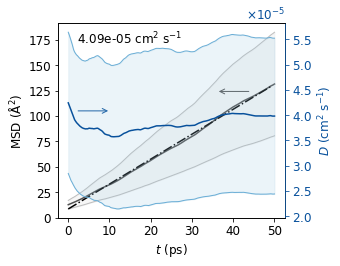

In [33]:
fig = plt.figure(figsize=(4.6,3.6))
ax  = fig.add_axes([0.16, 0.16, 0.685, 0.75])
color = "#08519c"
ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"], color = "#525252")

ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] - msd_d_df["MSD_error"], linewidth = 1, color = "#bdbdbd")
ax.plot(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] + msd_d_df["MSD_error"], linewidth = 1, color = "#bdbdbd")

ax.fill_between(msd_d_df["t"]/1000, msd_d_df["Mean_MSD"] + msd_d_df["MSD_error"], msd_d_df["Mean_MSD"] - msd_d_df["MSD_error"], color= "#d9d9d9", alpha = 0.2)

linear_model=np.polyfit(msd_d_df["t"]/1000,msd_d_df["Mean_MSD"],1)  
linear_model_fn=np.poly1d(linear_model) 

x_s=np.arange(msd_d_df["t"].min()/1000,msd_d_df["t"].max()/1000)  
ax.plot(x_s,linear_model_fn(x_s), color="k", ls ="-.")

ax1=ax.twinx()
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"], color = color)
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"] - msd_d_df["D_error"], linewidth = 1, color = "#6baed6")
ax1.plot(msd_d_df["t"]/1000, msd_d_df["Mean_D"] + msd_d_df["D_error"], linewidth = 1, color = "#6baed6")

ax1.fill_between(msd_d_df["t"]/1000, msd_d_df["Mean_D"] + msd_d_df["D_error"], msd_d_df["Mean_D"] - msd_d_df["D_error"], color = "#9ecae1", alpha = 0.2)

ax.annotate("", xy=(0.7, 0.65), xycoords = "axes fraction",
            xytext=(0.85, 0.65), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", color = "#525252"))

ax.annotate("", xy=(0.23, 0.55), xycoords = "axes fraction",
            xytext=(0.08, 0.55), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", color = color))

ymin, ymax = ax.get_ylim()

ax.text(15, ymin + 0.92*(ymax - ymin), "%.2e cm$^2$ s$^{-1}$"%(linear_model[0]/60000), ha = "center", va = "center")

ax.set_ylabel('MSD (Å$^2$)')
ax.set_xlabel('$t$ (ps)')
ax1.set_ylabel('$D$ (cm$^2$ s$^{-1}$)', color = color)
ax1.tick_params(axis='y', color = color, labelcolor = color)
ax1.spines['right'].set_color(color)
ax1.ticklabel_format(axis='y', style='sci', scilimits=[-4,4], useMathText=True)

# plt.savefig("average_msd_d_500K.jpg",dpi=600)
plt.show()

## Hydrogen bond analysis

### Indices of atoms that can form H-bonds

TFA anions

In [34]:
TFAs = (
    {
        "F1": 0,
        "F2": 1,
        "F3": 2,
        "O1": 3,
        "O2": 4,
        "C1": 5,
        "C2": 6,
    }, 
    {
        "F1": 7,
        "F2": 8,
        "F3": 9,
        "O1": 10,
        "O2": 11,
        "C1": 12,
        "C2": 13,
    }, 
    {
        "F1": 129,
        "F2": 130,
        "F3": 131,
        "O1": 132,
        "O2": 133,
        "C1": 134,
        "C2": 135,
    }, 
    {
        "F1": 136,
        "F2": 137,
        "F3": 138,
        "O1": 139,
        "O2": 140,
        "C1": 141,
        "C2": 142,
    }, 
    {
        "F1": 258,
        "F2": 259,
        "F3": 260,
        "O1": 261,
        "O2": 262,
        "C1": 263,
        "C2": 264,
    }, 
    {
        "F1": 265,
        "F2": 266,
        "F3": 267,
        "O1": 268,
        "O2": 269,
        "C1": 270,
        "C2": 271,
    }, 
    {
        "F1": 387,
        "F2": 388,
        "F3": 389,
        "O1": 390,
        "O2": 391,
        "C1": 392,
        "C2": 393,
    }, 
    {
        "F1": 394,
        "F2": 395,
        "F3": 396,
        "O1": 397,
        "O2": 398,
        "C1": 399,
        "C2": 400,
    }, 
)

In [35]:
TFA_formula = "F3O2C2"
# Make an empty atoms object
TFA_atoms = Atoms('', positions=[])
# Add water molecules in the atoms object
for i in range(len(TFAs)):
    indices = list(TFAs[i].values())
   
    TFA = Atoms(TFA_formula,
                positions = traj.frames[0][indices]["positions"],
               )
    TFA_atoms += TFA

render_atoms(TFA_atoms)

Hydroxyl groups and amines

In [36]:
phenols = (
    {"O":24, "H":25}, #
    {"O":411, "H":412}, #
    {"O":153, "H":154}, # H-bonded to water O 272
    {"O":282, "H":283}, # H-bonded to water O 143  
)

Amines = (
    {"N":410, "H1":284, "H2":285}, #H1 H-bond to TFA O 397
    {"N":409, "H":128}, # H-bond to TFA O 261
    {"N":407, "H1":28, "H2":29}, #H1 H-bond to TFA O 261, H2 H-bonded to TFA O 269
    {"N":152, "H1":26, "H2":27}, #
    {"N":149, "H1":286, "H2":287}, #
    {"N":151, "H":386,}, #

    {"N":280, "H":257}, #
    {"N":278, "H1":157, "H2":158}, #
    {"N":281, "H1":413, "H2":414}, #
    
    {"N":23, "H1":155, "H2":156}, # H1 155 H-bonded to TFA O 10 H2 156 H-bonded to water O 17
    {"N":22, "H1":515}, # H 149 H-bonded to TFA O 132
    {"N":20, "H1":415, "H2":416}, # H1 415 H-bonded to TFA O 132 H2 416 H-bonded to TFA O 140
)

### Preparing donor-acceptor and donor-hydrogen-acceptor atom pairs dicts. 

In [37]:
# Keep O and F only that can serve as H-bond acceptors
TFA_F_Os = TFAs
for TFA in TFA_F_Os:
    [TFA.pop(key) for key in list(TFA.keys()) if key == "C1" or key == "C2"] # keep F and O in TFAs only for H-bond analysis
    
TFA_F_Os

({'F1': 0, 'F2': 1, 'F3': 2, 'O1': 3, 'O2': 4},
 {'F1': 7, 'F2': 8, 'F3': 9, 'O1': 10, 'O2': 11},
 {'F1': 129, 'F2': 130, 'F3': 131, 'O1': 132, 'O2': 133},
 {'F1': 136, 'F2': 137, 'F3': 138, 'O1': 139, 'O2': 140},
 {'F1': 258, 'F2': 259, 'F3': 260, 'O1': 261, 'O2': 262},
 {'F1': 265, 'F2': 266, 'F3': 267, 'O1': 268, 'O2': 269},
 {'F1': 387, 'F2': 388, 'F3': 389, 'O1': 390, 'O2': 391},
 {'F1': 394, 'F2': 395, 'F3': 396, 'O1': 397, 'O2': 398})

In [38]:
atoms_dict = phenols + Amines + TFA_F_Os + waters
atoms_dict

({'O': 24, 'H': 25},
 {'O': 411, 'H': 412},
 {'O': 153, 'H': 154},
 {'O': 282, 'H': 283},
 {'N': 410, 'H1': 284, 'H2': 285},
 {'N': 409, 'H': 128},
 {'N': 407, 'H1': 28, 'H2': 29},
 {'N': 152, 'H1': 26, 'H2': 27},
 {'N': 149, 'H1': 286, 'H2': 287},
 {'N': 151, 'H': 386},
 {'N': 280, 'H': 257},
 {'N': 278, 'H1': 157, 'H2': 158},
 {'N': 281, 'H1': 413, 'H2': 414},
 {'N': 23, 'H1': 155, 'H2': 156},
 {'N': 22, 'H1': 515},
 {'N': 20, 'H1': 415, 'H2': 416},
 {'F1': 0, 'F2': 1, 'F3': 2, 'O1': 3, 'O2': 4},
 {'F1': 7, 'F2': 8, 'F3': 9, 'O1': 10, 'O2': 11},
 {'F1': 129, 'F2': 130, 'F3': 131, 'O1': 132, 'O2': 133},
 {'F1': 136, 'F2': 137, 'F3': 138, 'O1': 139, 'O2': 140},
 {'F1': 258, 'F2': 259, 'F3': 260, 'O1': 261, 'O2': 262},
 {'F1': 265, 'F2': 266, 'F3': 267, 'O1': 268, 'O2': 269},
 {'F1': 387, 'F2': 388, 'F3': 389, 'O1': 390, 'O2': 391},
 {'F1': 394, 'F2': 395, 'F3': 396, 'O1': 397, 'O2': 398},
 {'O': 14, 'H1': 15, 'H2': 16},
 {'O': 17, 'H1': 18, 'H2': 19},
 {'O': 143, 'H1': 144, 'H2': 145},

Visualise these atoms

In [39]:
atoms = Atoms('', positions=[])
# Add water molecules in the atoms object
for i in range(len(atoms_dict)):
    indices = list(atoms_dict[i].values())
    symbols = traj.frames[0][indices]["symbols"].tolist()
    positions = traj.frames[0][indices]["positions"]
    atoms += Atoms(symbols, positions)
    
render_atoms(atoms)

#### Find all possible combinations of donor - H - acceptor pairs

In [36]:
def retrieve_symbol(string):
    """function to remove numbers in a string, so that the atom dict keys can be converted to chemical symbols"""
    return ''.join([i for i in string if not i.isdigit()])

def find_d_a(atoms_dict):
    """
    Creat donor, acceptor dicts from atoms_dicts.
    """
    donors = []
    acceptors = []
    for a_dict in atoms_dict:
        symbols = [retrieve_symbol(key) for key in list(a_dict.keys())] # retrieve chemical symbol from atoms_dict keys
        if symbols[0] == "F":
            acceptors += (a_dict,)
        elif symbols[0] == "N":
            if len(symbols) == 2:
                donors += (a_dict,)
            else:
                combs = [{"N": a_dict["N"], x: a_dict[x]} for x in list(a_dict.keys()) if x != "N"]
                donors += (combs[0], combs[1])

        elif symbols[0] == "O":
            if symbols[0] == symbols[1]:
                acceptors += (a_dict,)
            elif len(symbols) == 2 and symbols[0] != symbols[1]:
                donors += (a_dict,)
            else:
                combs = [{"O": a_dict["O"], x: a_dict[x]} for x in list(a_dict.keys()) if x != "O"]
                donors += (combs[0], combs[1])
                acceptors += ({"O": a_dict["O"]},)
    print(f"Done! {len(donors)} donors and {len(donors)} acceptors were found!\n" + "Acceptors:\n", acceptors, "\n Donors:\n", donors)
    return donors, acceptors

In [37]:
donors, acceptors = find_d_a(atoms_dict = atoms_dict)

Done! 40 donors and 40 acceptors were found!
Acceptors:
 [{'F1': 0, 'F2': 1, 'F3': 2, 'O1': 3, 'O2': 4}, {'F1': 7, 'F2': 8, 'F3': 9, 'O1': 10, 'O2': 11}, {'F1': 129, 'F2': 130, 'F3': 131, 'O1': 132, 'O2': 133}, {'F1': 136, 'F2': 137, 'F3': 138, 'O1': 139, 'O2': 140}, {'F1': 258, 'F2': 259, 'F3': 260, 'O1': 261, 'O2': 262}, {'F1': 265, 'F2': 266, 'F3': 267, 'O1': 268, 'O2': 269}, {'F1': 387, 'F2': 388, 'F3': 389, 'O1': 390, 'O2': 391}, {'F1': 394, 'F2': 395, 'F3': 396, 'O1': 397, 'O2': 398}, {'O': 14}, {'O': 17}, {'O': 143}, {'O': 146}, {'O': 272}, {'O': 275}, {'O': 401}, {'O': 404}] 
 Donors:
 [{'O': 24, 'H': 25}, {'O': 411, 'H': 412}, {'O': 153, 'H': 154}, {'O': 282, 'H': 283}, {'N': 410, 'H1': 284}, {'N': 410, 'H2': 285}, {'N': 409, 'H': 128}, {'N': 407, 'H1': 28}, {'N': 407, 'H2': 29}, {'N': 152, 'H1': 26}, {'N': 152, 'H2': 27}, {'N': 149, 'H1': 286}, {'N': 149, 'H2': 287}, {'N': 151, 'H': 386}, {'N': 280, 'H': 257}, {'N': 278, 'H1': 157}, {'N': 278, 'H2': 158}, {'N': 281, 'H1': 413

In [38]:
def pair_d_a(donors, acceptors):
    """
    Make d_a_pairs and d_h_a_pairs from the donors and acceptors dict.
    """
    d_a_pairs = []
    d_h_a_pairs = []
    for donor in donors:
        d_atom = [{x: donor[x]} for x in list(donor.keys()) if not x.startswith("H")]
        for acceptor in acceptors:
            keys = list(acceptor.keys())

            if len(keys) == 1:
                symbol = list(d_atom[0].keys())[0]
                if symbol == "O" and d_atom[0][symbol] == acceptor[keys[0]]: # exclude combinations where donor and acceptor are the same oxygen atom.
                    print(f"Donor and acceptor is the same atom: {symbol} {acceptor[keys[0]]}, skipped.")
                    continue
                else:
                    d_a_pairs += [[d_atom[0], acceptor],]
                    d_h_a_pairs += [[donor, acceptor],]
            else:
                for key in keys:
                    d_a_pairs += [[d_atom[0], {key: acceptor[key]}],]
                    d_h_a_pairs += [[donor, {key: acceptor[key]}],]
    print(f"Unique donoar-acceptor/donoar-hydrogen-acceptor combinations: {len(d_a_pairs)}")
    print(f"Sample donor-acceptor pair: {d_a_pairs[0]}\nSample donor-hydrogen-acceptor pair: {d_h_a_pairs[0]}")
    return d_a_pairs, d_h_a_pairs

In [39]:
d_a_pairs, d_h_a_pairs = pair_d_a(donors = donors, acceptors = acceptors)

Donor and acceptor is the same atom: O 14, skipped.
Donor and acceptor is the same atom: O 14, skipped.
Donor and acceptor is the same atom: O 17, skipped.
Donor and acceptor is the same atom: O 17, skipped.
Donor and acceptor is the same atom: O 143, skipped.
Donor and acceptor is the same atom: O 143, skipped.
Donor and acceptor is the same atom: O 146, skipped.
Donor and acceptor is the same atom: O 146, skipped.
Donor and acceptor is the same atom: O 272, skipped.
Donor and acceptor is the same atom: O 272, skipped.
Donor and acceptor is the same atom: O 275, skipped.
Donor and acceptor is the same atom: O 275, skipped.
Donor and acceptor is the same atom: O 401, skipped.
Donor and acceptor is the same atom: O 401, skipped.
Donor and acceptor is the same atom: O 404, skipped.
Donor and acceptor is the same atom: O 404, skipped.
Unique donoar-acceptor/donoar-hydrogen-acceptor combinations: 1904
Sample donor-acceptor pair: [{'O': 24}, {'F1': 0}]
Sample donor-hydrogen-acceptor pair: [

### Resolve H-bonds in each frame of the trajectory

#### Functions to carry out geometry calculations

In [19]:
def cart2xys(pos, cell):
    """
    Cartesian (absolute) position in angstrom to fractional position (scaled position in lattice).
    """
    pos = np.asarray(pos)
    bg = np.linalg.inv(cell)
    xyzs = np.tensordot(bg, pos.T, axes=([-1], 0)).T
    return xyzs

def xys2cart(pos, cell):
    """
    Fractional position (scaled position in lattice) to cartesian (absolute) position in angstrom.
    """
    pos = np.asarray(pos)
    xyzr = np.tensordot(cell, pos.T, axes=([-1], 0)).T
    return xyzr

def theta(vec1, vec2):
    """
    Calculate the angle between two vectors.
    """
    return np.arccos(vec1.dot(vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))*180/np.pi

def at_dict2pos(at_dict, frame):
    """
    Converts the list of at_dict to list of positions
    """
    for item in at_dict:
        indices = (list(item.values()))
        positions = [frame[x]["positions"] for x in indices]
    return positions

def distance(atom_pair, frame, cell = None, mic = True):
    """
    Calculates the distance of a atom pair. If mic is True returns the distance of two atoms using minimum image convention.
    """
    indices = [list(atom_dict.values()) for atom_dict in atom_pair]
    indices = [item for sublist in indices for item in sublist] # Flatten the list of lists to a list of integers
    positions = [frame[x]["positions"] for x in indices]

    if mic:
        a2b = cart2xys(positions[1], cell = cell) - cart2xys(positions[0], cell = cell)
        for i in range(3):
            a2b[i] = a2b[i] - round(a2b[i])
        a2b = xys2cart(a2b, cell = cell)
    else:
        a2b = positions[1] - positions[0]
    return np.sqrt(np.dot(a2b, a2b))

#### Function to resolve hydrogen bonds by geometry criteria

In [21]:
vdW_R = {"O": 1.52, "N": 1.55, "F": 1.47,} # van der Waals radii
def res_hbonds(d_a_pairs, d_h_a_pairs, frames, cell = None):
    """
    Calculates the H-bond information in each frame of the trajectory.
    """
    results = []
    for i, frame in enumerate(frames):
        hbonds = [] #list to store all hbonds in current frame
        for d_a_pair, d_h_a_pair in zip(d_a_pairs, d_h_a_pairs):
            # Sum of van der Waals radii
            symbols = [list(atom_dict.keys()) for atom_dict in d_a_pair]
            symbols = [item for sublist in symbols for item in sublist] # flatten the list of lists
            symbols = [retrieve_symbol(symbol) for symbol in symbols] # Remove numbers and get chemical symbol from atoms_dict to be ready to pass to the vdW radii dict
            vdW_sum = vdW_R[symbols[0]] + vdW_R[symbols[1]]
            
            # not a H-bond of D-A distance is greater than their vdW radii times 1.05, 1.05 to take bond length change during MD simulation.
            r_d_a = distance(d_a_pair, frame, cell = cell, mic = True)  # calculate the D-A distance
            if r_d_a < 1.02 * vdW_sum:
                # calculate the D-H⋅⋅⋅A angle
                d_h_pos = at_dict2pos ([d_h_a_pair[0],], frame) # the positions of donor and hydrogen
                a_pos = at_dict2pos([d_h_a_pair[1],], frame) # the positions of acceptor
                d_h_vec = d_h_pos[1] - d_h_pos[0]
                a_h_vec = d_h_pos[1] - a_pos[0]
                d_h_a_ang = theta(d_h_vec, a_h_vec) # angle
                d_h = distance([d_h_a_pair[0],], frame, cell = cell, mic = True) # calculate the D-H length
            
                # the D-H⋅⋅⋅A angle criteria used: the D-H⋅⋅⋅A angle is close to a right angle refer to the D-H⋅⋅⋅A angle - R(D⋅⋅⋅A) plot
                # an angle range is included considering the oscillation of bond lenghth and anlgle
                if d_h_a_ang >= (np.rad2deg(np.arctan2(r_d_a, d_h)) + 180)*3/8:
                # if d_h_a_ang >= 90:
                    # Store current H-bond
                    hbonds.append(
                          {
                              "donor": d_h_a_pair[0],
                              "acceptor": d_h_a_pair[1],
                              "R(D-A)": r_d_a,
                              "DHA_ang": d_h_a_ang,
                              "r(D-H)": d_h,
                          }
                    )
                
        results.append({f"frame": i, "n_hbonds": len(hbonds), "hbonds": hbonds})
    return results

#### Search H-bonds in each frame and store the results in a `json` file

The periodic simulation cell

In [18]:
cell= [
    [21.2944000000,        0.0000000000,        0.0000000000],
    [-4.6030371123,       20.7909480472,        0.0000000000],
    [-0.9719093466,       -1.2106211379,       15.1054299403]
]

In [43]:
import json

In [23]:
# This can take hours for large trajectory files, the time shown in the output is for 1000 frames
%%time
hbonds = res_hbonds(d_a_pairs=d_a_pairs, d_h_a_pairs=d_h_a_pairs, frames = traj, cell = cell)
import json
with open("cage1/hbonds_mic.json", "w") as json_file:
    json.dump(hbonds, json_file)
json_file.close()

CPU times: user 3min 7s, sys: 2min 29s, total: 5min 36s
Wall time: 1min 52s


In [67]:
# print the first five H-bonds in the first frame
import pprint
pprint.pprint(hbonds[0]["hbonds"][:5])

[{'DHA_ang': 139.79612411020426,
  'R(D-A)': 2.1851514504237652,
  'acceptor': {'O': 401},
  'donor': {'H': 25, 'O': 24},
  'r(D-H)': 0.9547274497922961},
 {'DHA_ang': 146.3980925974079,
  'R(D-A)': 2.969525691114618,
  'acceptor': {'O2': 269},
  'donor': {'H1': 284, 'N': 410},
  'r(D-H)': 1.1086150193450304},
 {'DHA_ang': 148.16202661104714,
  'R(D-A)': 2.8128852128230815,
  'acceptor': {'O1': 397},
  'donor': {'H2': 285, 'N': 410},
  'r(D-H)': 1.0630735844179962},
 {'DHA_ang': 170.63042286845385,
  'R(D-A)': 2.6892733597881184,
  'acceptor': {'O2': 262},
  'donor': {'H1': 28, 'N': 407},
  'r(D-H)': 1.0468935997416686},
 {'DHA_ang': 169.11846969196978,
  'R(D-A)': 2.973093058870144,
  'acceptor': {'O': 14},
  'donor': {'H2': 29, 'N': 407},
  'r(D-H)': 1.0819685841190514}]


#### Visualisation of the H-bond data

In [44]:
# Opening JSON file
f = open('cage1/hbonds_mic.json')
 
# returns JSON object as a dictionary
hbonds = json.load(f)
 
# Iterating through the json list
nhbonds=[]
d_h_a_ang = []
r_d_a = []
for hbond in hbonds:
    nhbonds.append(hbond["n_hbonds"])
    a = hbond["hbonds"]
    for element in a:
        r_d_a.append(element["R(D-A)"])
        d_h_a_ang.append(element["DHA_ang"])

In [45]:
start_idx = 0
t0 = start_idx * 5
t_end = t0 + 5*(10001-1) # 5 fs is the interval of traj
t = np.linspace(t0, t_end, num = 10001)/1000
t

array([0.0000e+00, 5.0000e-03, 1.0000e-02, ..., 4.9990e+01, 4.9995e+01,
       5.0000e+01])

In [46]:
data = np.array(nhbonds)/1904 # Unique donoar-acceptor/donoar-hydrogen-acceptor combinations found by pair_d_a function: 1904
print(data.mean())
print(data.std())
data = pd.DataFrame({"nhbonds": data})
data.head()

0.008758682955233887
0.0019027068773261652


,nhbonds
0,0.009979
1,0.009979
2,0.010504
3,0.009979
4,0.009979


In [47]:
mean = data.rolling(50, center=True).mean()

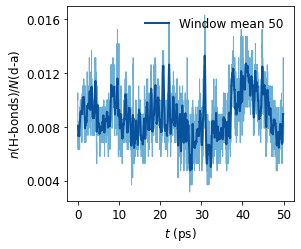

In [48]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()
ax.plot(t, np.array(nhbonds)/1904, color ="#6baed6", lw = 1)
ax.plot(t, mean["nhbonds"], color ="#08519c", lw = 2, label = "Window mean 50")

ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$n$(H-bonds)/$N$(d-a)")

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(0.004))
plt.legend(frameon = False)
# plt.savefig("nhbonds.jpg", dpi = 600)
plt.show()

### H-bond lifetime analysis

#### Define functions to enable the calculation of $C_t$

A time autocorrelation function can be used to describe the hydrogen bond dynamics ([D. C Rapaport, Mol. Phys. 1983](https://doi.org/10.1080/00268978300102931), [R. J. Gowers and P. Carbone, J. Chem. Phys. 2015](https://doi.org/10.1063/1.4922445)):

$$
C_t=\langle \frac {\sum h_{ij} (t_0 ) h_{ij} (t_0+t)} {\sum h_{ij} (t_0 )^2} \rangle
$$

Where $h_{ij}$ is a binary function which takes one if a hydrogen donor-acceptor pair $i-j$ forms a hydrogen bonding according to the geometry criteria and otherwise takes zero. The summation counts the number of hydrogen bonds formed for the start time t0 and the time $t_0 + t$. The squared angle denotes the average of different start time $t_0$.

The autocorrelation functions can be fitted by a biexponential function ([R. J. Gowers and P. Carbone, J. Chem. Phys. 2015](https://doi.org/10.1063/1.4922445)):

$$
C_t = A e^{- \frac {t} {\tau_1}} + (1-A) e^{- \frac {t} {\tau_2}}
$$

And the H-bond lifetime $\tau$ can be calculated by integrating the fitted $C_t$:

$$
\tau = \int_0^\infty(C(t)-\langle C(t=\infty)\rangle)dt
$$


In [49]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def to_sublists(lst, length=2):
    """
    Split a list to sublists with specified length: e.g. a = [a,b,c,d,e]
    to_sublists(a) => [[a,b], [b,c], [c,d], [d,e]] 
    """
    return [lst[i:i+length] for i in range(len(lst)+1-length)]

def bi_exp(t, amp1, tau1, tau2):
    return amp1*np.exp(-t/tau1) + (1-amp1)*np.exp(-t/tau2)


def bi_exp_fit(x, y, amp1 = 0.5, tau1 = 100, tau2 = 150):
    """
    Fit the data with biexponential function
    """
    params,_ = curve_fit(bi_exp, x, y, p0=[amp1, tau1, tau2])
    x_fit = np.linspace(x.min(), x.max(), num = 200)
    y_fit = bi_exp(x_fit, *params)
    print("The fitted biexponential function paramters are:\nA: {0}, tau1: {1}, tau2: {2}".format(*params))
    return x_fit, y_fit, params

def calc_tau(amp1, tau1, tau2):
    """
    Calculates the H-bond lifetime by integrating the biexponential function.
    """
    def function(x):
        return amp1*np.exp(-x/tau1) + (1 - amp1)*np.exp(-x/tau2)

    res, err = quad(function, 0, np.inf)
    print(f"The H-bond lifetime is {res} ps.")
    return res

def auto_cor(nframes = 1000, skip = 100, data = "hbonds.json", index = 600):
    """
    Calculates the autocorrelation function of H-bonds from a trajectory.
    """
    # Opening JSON data file containing the hbonds information
    f = open(data)

    # returns JSON object as a dictionary
    if index == ":":
        frames = json.load(f)
        
    elif type(index) == int:
        frames = json.load(f)[:index]
        
    elif type(index) == list:
        frames = json.load(f)[index[0]:index[1]]
    
    frame_chunks = to_sublists(frames, nframes)

    C_ts = np.zeros((len(frame_chunks), nframes//skip))
    
    for i, frame_chunk in enumerate(frame_chunks):
        select = frame_chunk[::skip]
        nbonds_0 = nbonds = select[0]["n_hbonds"] # hij(t0)
        # store the donor and acceptor dicts in to a list
        hbonds_0 = select[0]["hbonds"]
        # for hbond_0 in hbonds_0:
        d_a_list_0 = [[hbonds_0[x]["donor"], hbonds_0[x]["acceptor"]] for x in range(len(hbonds_0))] # start point of h-bonds
        
        C_t = []
        for j, frame in enumerate(select):
            hbonds = frame["hbonds"]
            
            # Make a list of donor and acceptor for each frame
            d_a_list = [[hbonds[x]["donor"], hbonds[x]["acceptor"]] for x in range(len(hbonds))] # start point of h-bonds

            # Iterate through the elements in hbonds_0, if any hbond breaks (not in the list of hbonds in a frame), remove the hbond from d_a_list_0, and nbonds decreases by one
            for k, item in enumerate(d_a_list_0):
                if item not in d_a_list:
                    d_a_list_0.pop(k)
                    nbonds -= 1
            # Calculate the C(t)
            C_t.append(nbonds*nbonds_0/nbonds_0**2)
        C_ts[i] = np.array(C_t)
    # Calculate the mean and error of C_ts
    C_ts_mean = C_ts.mean(axis = 0)
    C_ts_error = C_ts.std(axis = 0)/(len(frames)//nframes)**0.5
    t_end = 0 + (nframes - 1)*5 # 5 fs is the interval of traj
    t = np.linspace(0, t_end, num = nframes//skip)/1000
    return t, C_ts_mean, C_ts_error

In [50]:
t, C_ts_mean, C_ts_error = auto_cor(nframes = 5000, skip = 100, data = "cage1/hbonds_mic.json", index = [0, 10001])
C_ts_mean

array([1.        , 0.73354026, 0.55864973, 0.44457555, 0.36547921,
       0.30743012, 0.26743443, 0.23488823, 0.21036029, 0.18922005,
       0.17154537, 0.15425202, 0.13858461, 0.12520593, 0.11366342,
       0.10338185, 0.0942756 , 0.08673871, 0.07963419, 0.07292497,
       0.06699419, 0.06220131, 0.05803781, 0.05449043, 0.0508166 ,
       0.04820921, 0.04596972, 0.04348287, 0.04088297, 0.03823241,
       0.03567413, 0.03312184, 0.0307567 , 0.02837254, 0.02633177,
       0.02439307, 0.0224348 , 0.02045987, 0.01876467, 0.01747706,
       0.01623992, 0.01501492, 0.01386458, 0.01291977, 0.01196202,
       0.0110823 , 0.01018169, 0.00924539, 0.008336  , 0.00746699])

In [52]:
x_fit, y_fit, params = bi_exp_fit(t, C_ts_mean, amp1 = 0.35922814, tau1 = 5.98152426, tau2 = 1.22001)
tau = calc_tau(*params)

The fitted biexponential function paramters are:
A: 0.365644265979071, tau1: 6.263185016672512, tau2: 1.103472909396457
The H-bond lifetime is 2.9900920555247583 ps.


#### Visualise the $C_t$

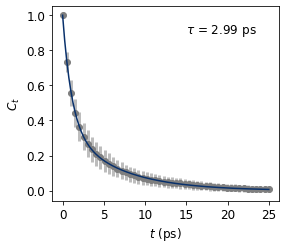

In [53]:
fig, ax = plt.subplots()

ax.errorbar(t, C_ts_mean, yerr=C_ts_error, fmt='o', color="tab:grey",
                    ecolor='#bdbdbd', elinewidth=3, capsize=0, zorder = 0); 
ax.plot(x_fit, y_fit, color = "#08306b", zorder = 1)

ax.text(15.0, 0.9, r"$\tau$ = %.2f ps"%tau)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$C_t$")
# plt.savefig("cage1_hbond_lifetime_500K.tif", dpi = 600)
plt.show()